In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from sklearn.linear_model import LinearRegression
from matplotlib.ticker import FixedLocator

In [36]:
ds = pd.read_csv("/Users/arinafedotova/archive/Cleaned_ships_data.csv")

In [37]:
print(ds.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Company_Name  200 non-null    object
 1   ship_name     200 non-null    object
 2   built_year    200 non-null    int64 
 3   gt            200 non-null    int64 
 4   dwt           200 non-null    int64 
 5   length        200 non-null    int64 
 6   width         200 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 11.1+ KB
None


In [136]:
ds.head(15)

,Company_Name,ship_name,built_year,gt,dwt,length,width,dwt_bins
0,PRELUDE,Offshore Support Vessel,2017,499167,394330,489,74,"(381054.3, 400694.0]"
1,MSC LORETO,Container Ship,2023,236184,240000,399,60,"(223936.7, 243576.40000000002]"
2,MSC FEBE,Container Ship,2019,232618,228149,400,62,"(223936.7, 243576.40000000002]"
3,MSC ARINA,Container Ship,2019,228741,228111,400,61,"(223936.7, 243576.40000000002]"
4,EVER GOVERN,Container Ship,2019,219688,198937,400,59,"(184657.30000000002, 204297.0]"
5,MAASTRICHT MAERSK,Container Ship,2019,214286,190326,399,59,"(184657.30000000002, 204297.0]"
6,ONE TREASURE,Container Ship,2018,210691,189766,400,58,"(184657.30000000002, 204297.0]"
7,ORE SHENZHEN,Bulk Carrier,2018,203953,398997,362,65,"(381054.3, 400694.0]"
8,SAHAM MAX,Bulk Carrier,2013,201705,400694,360,65,"(381054.3, 400694.0]"
9,BARZAN,Container Ship,2015,195636,199744,400,59,"(184657.30000000002, 204297.0]"


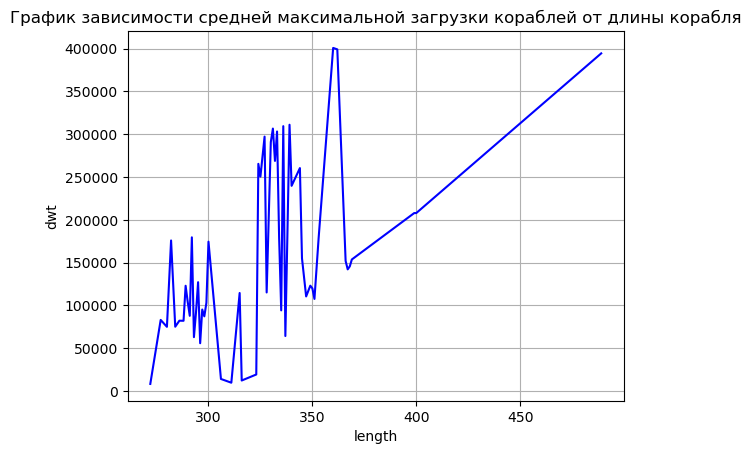

In [145]:
# построение График зависимости средней максимальной загрузки кораблей от длины корабля
ds_length_dwt = ds.groupby(by = 'length')['dwt'].mean()

x = list(ds_length_dwt.index.tolist())
y = list(ds_length_dwt.tolist())
plt.plot(x, y, color='blue') 
plt.title('График зависимости средней максимальной загрузки кораблей от длины корабля') 
plt.xlabel('length') 
plt.ylabel('dwt') 
plt.grid()  
plt.show()  

In [146]:
# Распределение количества кораблей по их типу
ds_name_count = dict()
for i in set(ds.get('ship_name')):
    ds_name_count[i] = 0
    for j in range(len(ds)):
        if ds.loc[j][1] == i:
            ds_name_count[i] += 1
ds_name_count = dict(sorted(ds_name_count.items(), key = lambda item: item[1]))

median = sum(ds_name_count.values())/len(ds_name_count)
count = 0
while min(ds_name_count.values()) < median:
    count += list(ds_name_count.values())[0]
    del ds_name_count[list(ds_name_count.keys())[0]]
if count:
    ds_name_count["Other"] = count
    
print(ds_name_count)

{'LNG Tanker': 31, 'Crude Oil Tanker': 36, 'Container Ship': 51, 'Bulk Carrier': 68, 'Other': 14}


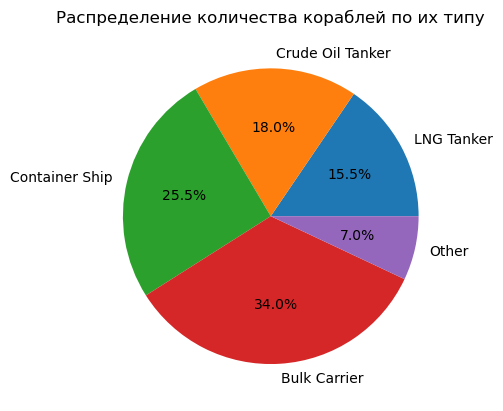

In [42]:
names = list(ds_name_count.keys())
count = list(ds_name_count.values())
plt.pie(count, labels = names, autopct='%1.1f%%') 
plt.title('Распределение количества кораблей по их типу') 
plt.show() 

In [43]:
# Гистограмма распределения количества кораблей по годам постройки
ds_year_count = dict()
for i in set(ds.get('built_year')):
    ds_year_count[i] = 0
    for j in range(len(ds)):
        if ds.loc[j][2] == i:
            ds_year_count[i] += 1
ds_year_count = dict(sorted(ds_year_count.items()))
print(ds_year_count)
print(len(ds_year_count))

{1976: 1, 1990: 1, 1992: 1, 1993: 2, 1994: 1, 1995: 2, 1996: 2, 1997: 2, 1999: 3, 2000: 1, 2001: 1, 2002: 2, 2003: 5, 2004: 5, 2005: 3, 2006: 2, 2007: 4, 2008: 8, 2009: 8, 2010: 14, 2011: 21, 2012: 15, 2013: 8, 2014: 14, 2015: 12, 2016: 14, 2017: 7, 2018: 9, 2019: 12, 2020: 5, 2021: 6, 2022: 7, 2023: 2}
33


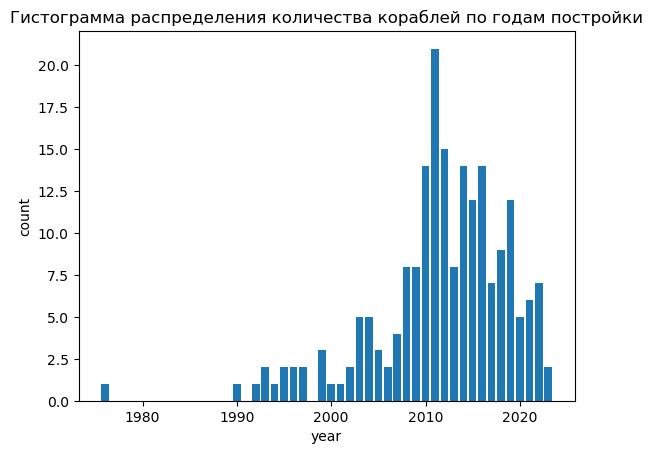

In [44]:
plt.bar(ds_year_count.keys(), ds_year_count.values())
plt.xlabel('year')
plt.ylabel('count')
plt.title('Гистограмма распределения количества кораблей по годам постройки') 
plt.show() 

In [154]:
#Гистограмма распределения количества кораблей по годам постройки (built_year) и максимальному весу груза (dwt)
dwt_bins = 20
dwt_min = ds['dwt'].min()
dwt_max = ds['dwt'].max()
dwt_step = (dwt_max - dwt_min) / dwt_bins

ds_year = sorted(list(set(ds.get('built_year'))))

# Новый столбец с интервалами 
#группирует элементы данных, указанные в первом аргументе, по интервалам, переданным во втором аргументе
ds['dwt_bins'] = pd.cut(ds['dwt'], bins=pd.interval_range(start=dwt_min, end=dwt_max, periods=dwt_bins))
# 'built_year' и 'dwt_bins' - столбцы, а элементы таблицы - количество судов в каждом бине 'dwt' для каждого года постройки
grouped_data = ds.groupby(['built_year', 'dwt_bins']).size().unstack(fill_value=0)
print(ds[['dwt', 'built_year', 'dwt_bins']])
#Индексы 'built_year' и 'dwt_bins' становятся столбцами, а элементы таблицы показывают количество судов 
#в каждом бине 'dwt' для каждого года постройки
# Сохранение полученных значений в список ds_count_dwt
ds_count_dwt = grouped_data.reindex(ds_year, fill_value=[0]*20).values.tolist()

print(ds_count_dwt)

        dwt  built_year                        dwt_bins
0    394330        2017            (381054.3, 400694.0]
1    240000        2023  (223936.7, 243576.40000000002]
2    228149        2019  (223936.7, 243576.40000000002]
3    228111        2019  (223936.7, 243576.40000000002]
4    198937        2019  (184657.30000000002, 204297.0]
..      ...         ...                             ...
195  180242        2010  (165017.6, 184657.30000000002]
196  179719        2010  (165017.6, 184657.30000000002]
197  179719        2012  (165017.6, 184657.30000000002]
198  180310        2004  (165017.6, 184657.30000000002]
199  176283        2011  (165017.6, 184657.30000000002]

[200 rows x 3 columns]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 

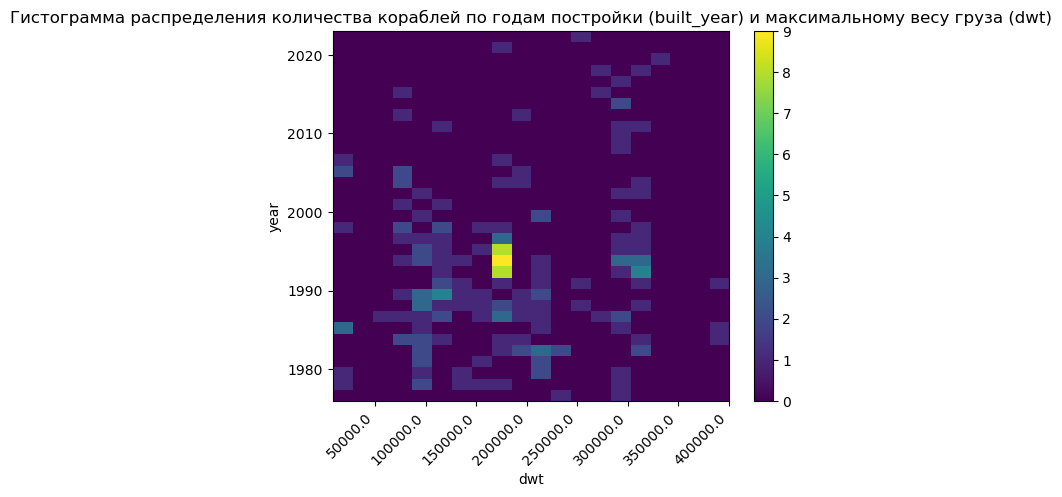

In [140]:
fig, ax = plt.subplots()
im = ax.imshow(ds_count_dwt, aspect='auto', extent=[dwt_min, dwt_max, min(ds_year), max(ds_year)])
plt.colorbar(im)
ax.xaxis.set_major_locator(plt.FixedLocator(ax.get_xticks()))
ax.set_xticklabels(ax.get_xticks(), rotation=45, ha='right')

plt.xlabel('dwt')
plt.ylabel('year')
plt.title('Гистограмма распределения количества кораблей по годам постройки (built_year) и максимальному весу груза (dwt)') 
plt.show() 

In [159]:
import seaborn as sns
ds_iris = pd.read_csv("IRIS.csv")
ds_iris

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


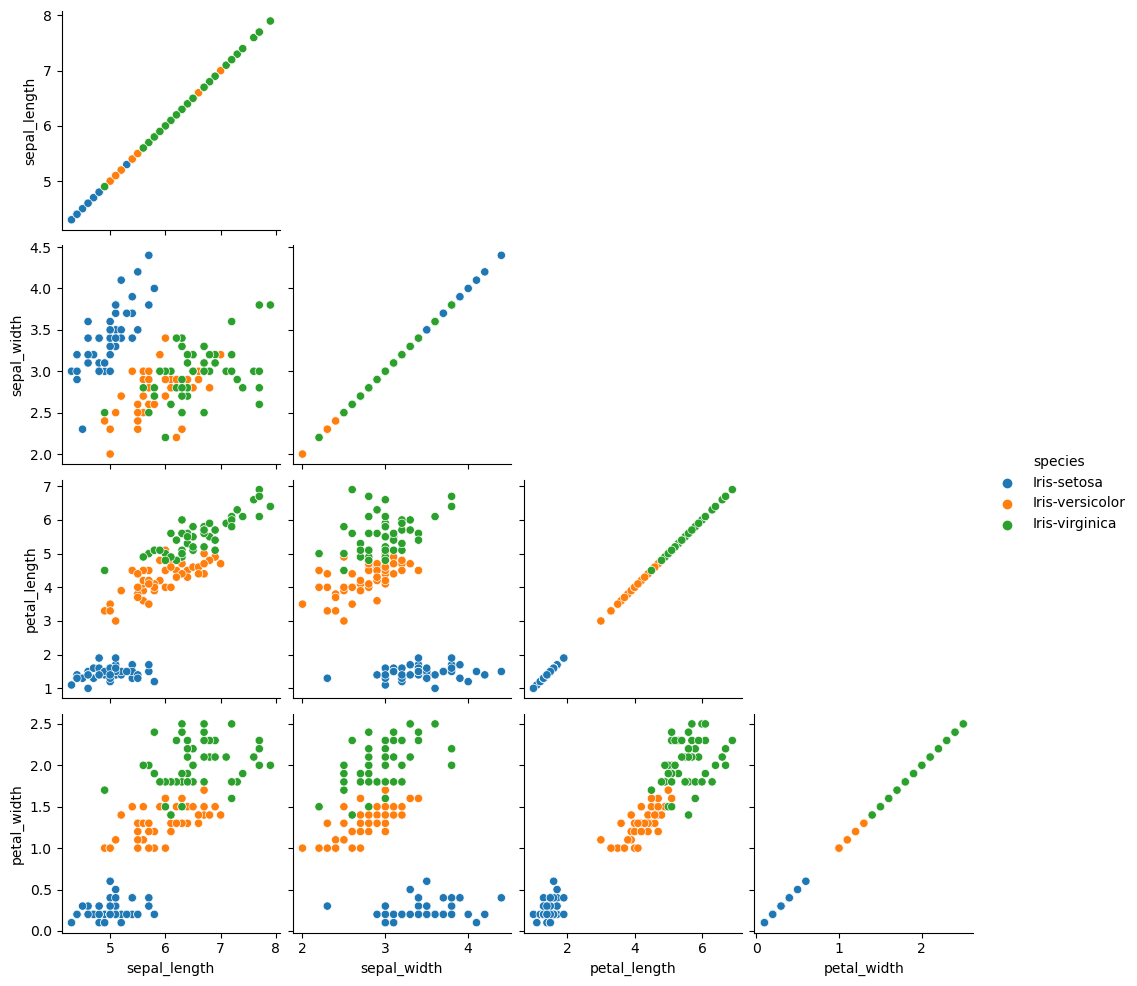

In [173]:
sns.pairplot(ds_iris, hue = 'species', diag_kind = None, corner=True)

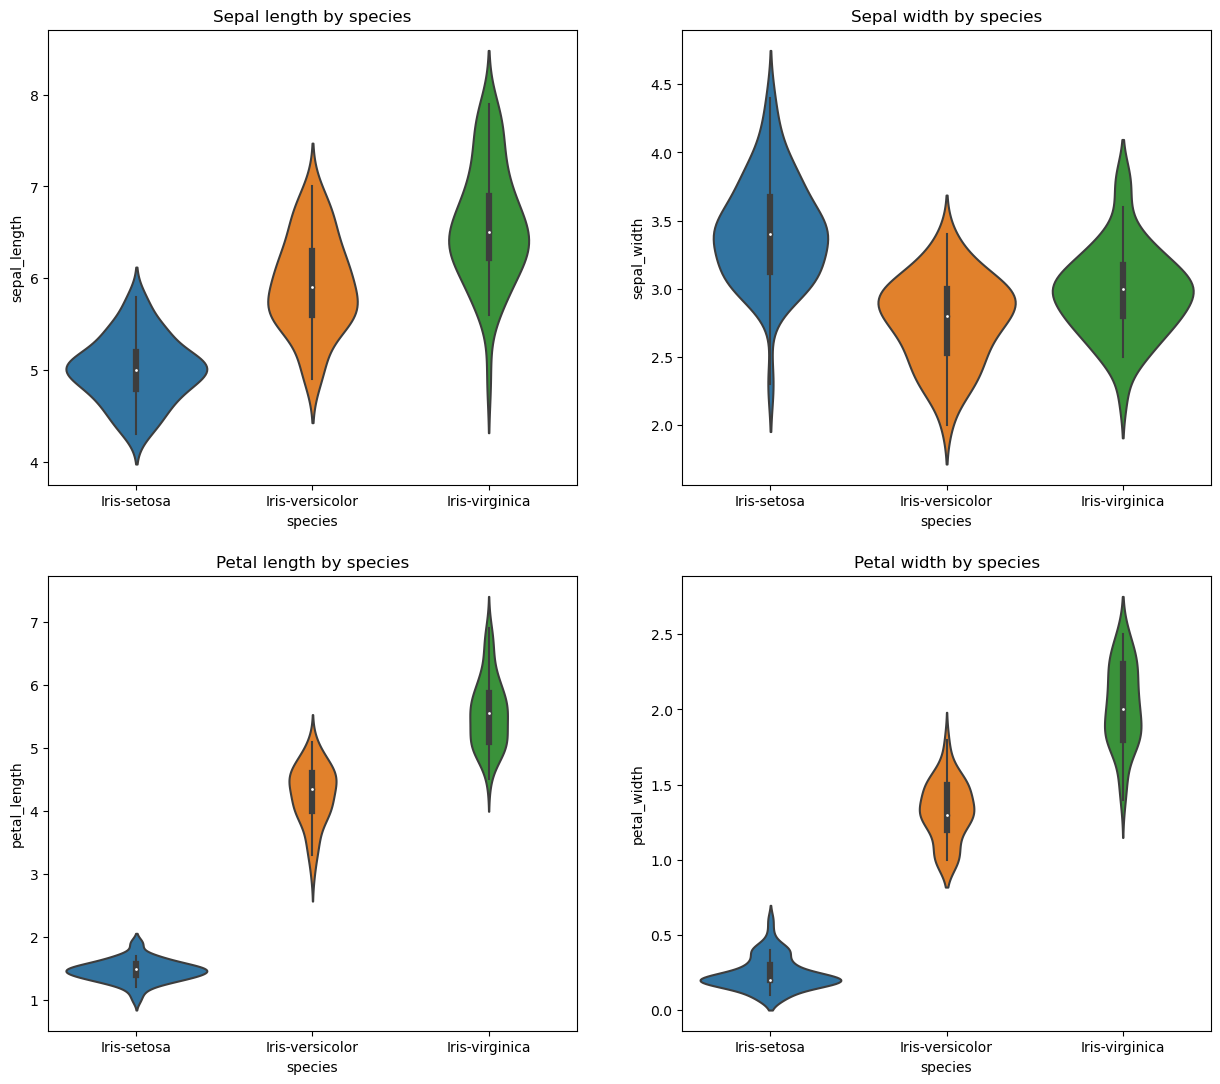

In [163]:
headers = list(ds_iris.columns.values)
titles = ['Sepal length by species', 'Sepal width by species', 'Petal length by species', 'Petal width by species']

plt.figure(figsize=(15, 13))

for i in range(len(headers)-1):
    plt.subplot(2,2,i+1)
    plt.title(headers[i])
    sns.violinplot(x = 'species', y = headers[i], data = ds_iris)
plt.show()

In [ ]:
# ЗАДАНИЕ 2

In [53]:
ds_heart = pd.read_csv("heart.csv")
ds_heart.head(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
5,39,M,NAP,120,339,0,Normal,170,N,0.0,Up,0
6,45,F,ATA,130,237,0,Normal,170,N,0.0,Up,0
7,54,M,ATA,110,208,0,Normal,142,N,0.0,Up,0
8,37,M,ASY,140,207,0,Normal,130,Y,1.5,Flat,1
9,48,F,ATA,120,284,0,Normal,120,N,0.0,Up,0


In [55]:
ds_heart.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [80]:
ds_heart.describe(include = ['object']) 

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


In [59]:
ds_heart.groupby(by = 'Sex')['HeartDisease'].count()

Sex
F    193
M    725
Name: HeartDisease, dtype: int64

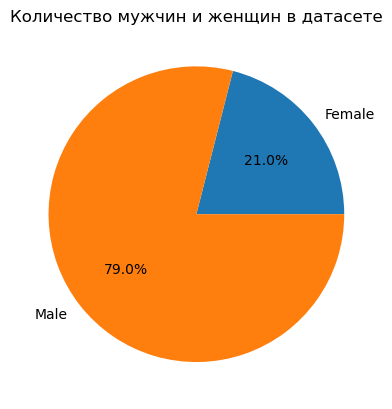

In [224]:
plt.pie(ds_heart.groupby(by = 'Sex').size(), labels = ["Female", "Male"], autopct='%1.1f%%') 
plt.title('Количество мужчин и женщин в датасете') 
plt.show()

Мужчины больше обращаются с проблемами с сердцем, чем женщины

In [62]:
ds_heart.ChestPainType.value_counts(dropna = False)

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64

ChestPainType
ASY    496
NAP    203
ATA    173
TA      46
Name: count, dtype: int64
['ASY', 'NAP', 'ATA', 'TA']


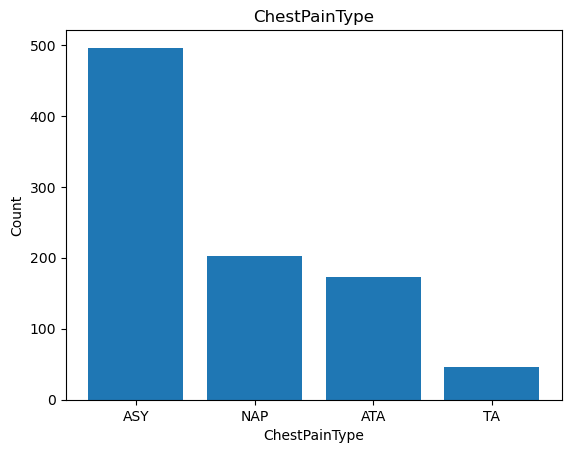

In [223]:
ds_chest_pain_type = ds_heart.ChestPainType.value_counts(dropna = False)
print(ds_chest_pain_type)
print(ds_chest_pain_type.index.tolist())
plt.title('ChestPainType')
plt.xlabel('ChestPainType')
plt.ylabel('Count')
plt.bar(ds_chest_pain_type.index.tolist(), ds_chest_pain_type.tolist())
plt.show()

Существует множетво типов болей в груди, которые могут быть вызваны разными причинами  
Чаще всего бессимптомно(±500), это означает, что у человека может быть проблема с сердцем, но он не чувствует никаких характерных болевых ощущений в груди. 
При этом типичная стенокардия есть у наименьшего числа людей(<60)  
Нестенокардической болезнью обладают ±200  
Атипичной стенокардией <200  

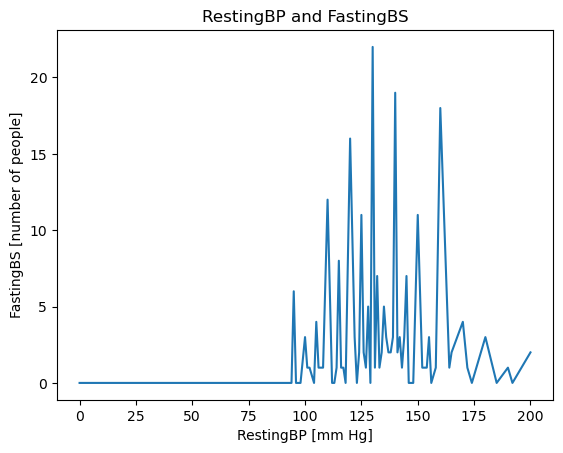

In [240]:
mean_by_age = ds_heart.groupby(by = 'RestingBP')['FastingBS'].sum()
plt.ylabel('FastingBS [number of people]')
plt.xlabel('RestingBP [mm Hg]')
plt.plot(mean_by_age.index.tolist(), mean_by_age.tolist())
plt.title('RestingBP and FastingBS')
plt.show()

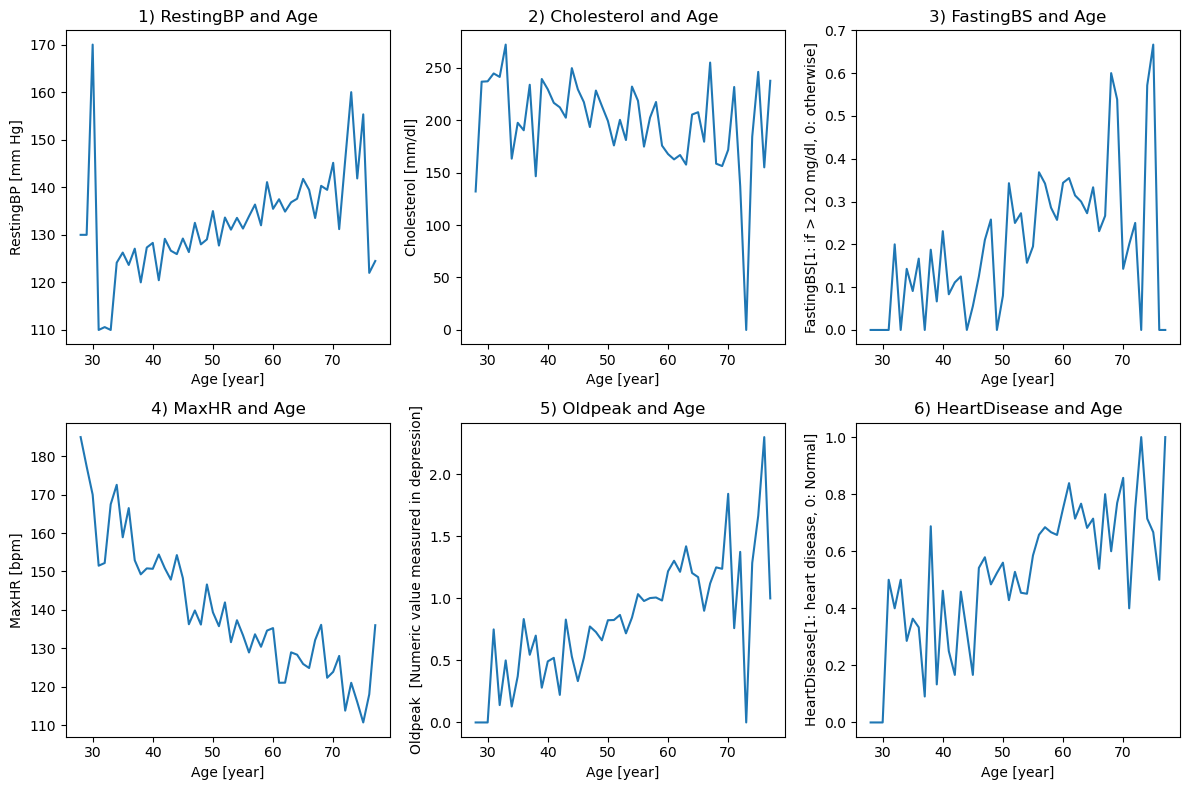

In [238]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
rows, cols = 2, 3

num_cols=['RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'Oldpeak', 'HeartDisease']
name_cols = ['RestingBP [mm Hg]', 'Cholesterol [mm/dl]', 'FastingBS[1: if > 120 mg/dl, 0: otherwise]', 
             'MaxHR [bpm]', 'Oldpeak  [Numeric value measured in depression]', 'HeartDisease[1: heart disease, 0: Normal]']
counter = 0

for row in range(rows):
    for col in range(cols):
        mean_by_age = ds_heart.groupby(by = 'Age')[num_cols[counter]].mean()
        axs[row, col].set_ylabel(name_cols[counter])
        axs[row, col].set_xlabel('Age [year]')
        axs[row, col].plot(mean_by_age.index.tolist(), mean_by_age.tolist())
        axs[row, col].set_title(str(counter+1) + ') ' + num_cols[counter] + ' and Age')
        counter+=1
        
fig.tight_layout()
plt.show()

1) Показатели артериального давления в целом имеют медленно возрастающую динамику с увеличением возраста, за исключением некоторых атипичных показателей у некоторых людей
2) Уровень холестирина не зависит от возраста (в датасете есть тольо один человек 73 летнего возраста и у него уровень холестирина равен 0, что объясняет резкий провал на графике)
3) Чаще всего повышенный уровень глюкозы у людей старше 65 лет, реже всего у людей до 50 (10%), 30% людей в возрасте от 50 до 66 имеют повышенный уровень глюкозы
4) Максимальное ЧСС падает с возрастом, связано со снижением физической активноти и естественным старением организма (сердечная мышца слабеет)
5) Значение депрессии сегмента ST (отклонением от нормального базового уровня сегмента ST) на ЭКГ (электрокардиограмме) после физической нагрузки. Он является индикатором сердечной ишемии, что означает недостаточное поступление крови (и, следовательно, кислорода) в сердечную мышцу. С возрастом этот показатель увеличивается, что говорит о том, что физическую нагрузку с возрастом сердцу тяжелее переносить 
6) Чем старше человек, тем больше вероятность появления сердечных заболеваний

Вывод: Люди старше 50 имеют повышенное артериальное давление, диабет, низкое максимальное ЧСС, значение депрессии сегмента ST выше 1 наиболее подвержены сердечным заболеваниям

In [103]:
ds_heart.tail(10)

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
908,63,M,ASY,140,187,0,LVH,144,Y,4.0,Up,1
909,63,F,ASY,124,197,0,Normal,136,Y,0.0,Flat,1
910,41,M,ATA,120,157,0,Normal,182,N,0.0,Up,0
911,59,M,ASY,164,176,1,LVH,90,N,1.0,Flat,1
912,57,F,ASY,140,241,0,Normal,123,Y,0.2,Flat,1
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1
917,38,M,NAP,138,175,0,Normal,173,N,0.0,Up,0


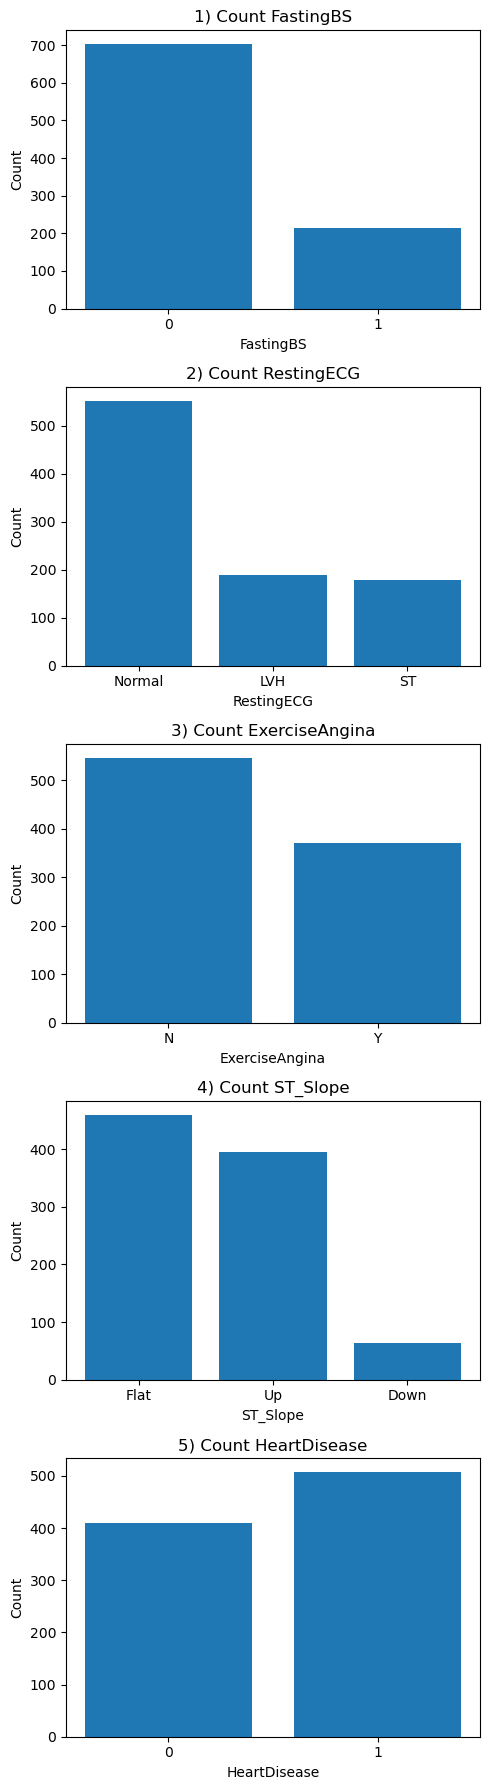

In [227]:
fig, axs = plt.subplots(5, 1, figsize=(5, 18))
rows = 5

categorical_features = ['FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope', 'HeartDisease']
counter = 0

for row in range(rows):
    if counter == len(categorical_features):
        break
    count_category = ds_heart[categorical_features[counter]].value_counts(dropna = False)
    axs[row].set_xlabel(categorical_features[counter])
    axs[row].set_ylabel('Count')
    axs[row].bar(count_category.index.tolist(), count_category.tolist())
    axs[row].set_xticks(count_category.index.tolist()) 
    axs[row].set_title(str(counter + 1) + ') Count ' + categorical_features[counter])
    counter+=1
        
fig.tight_layout()
plt.show()


1) Больше людей в датасете без сахарного диабета
2) У большинства людей показатели ЭКГ в норме, в 2,5 раз реже у людей наблюдаются ST(гипоксия (кислородная недостаточность) в сердечной мышце, а также признаки инфаркта миокарда) и LVH(наличие гипертрофии левого желудочка)
3) Стенокардия, вызванная физической нагрузкой реже в примерно 1,5 раза
4) St_slope отражает период между окончанием сокращения сердца и началом следующего сокращения, Up считается нормой, Down - признак ишемии (недостаточное кровоснабжение), flat - требуется дополнительное обследование

5) Наличие сердечных заболеваний примерно на 100 больше чем их отсутствие

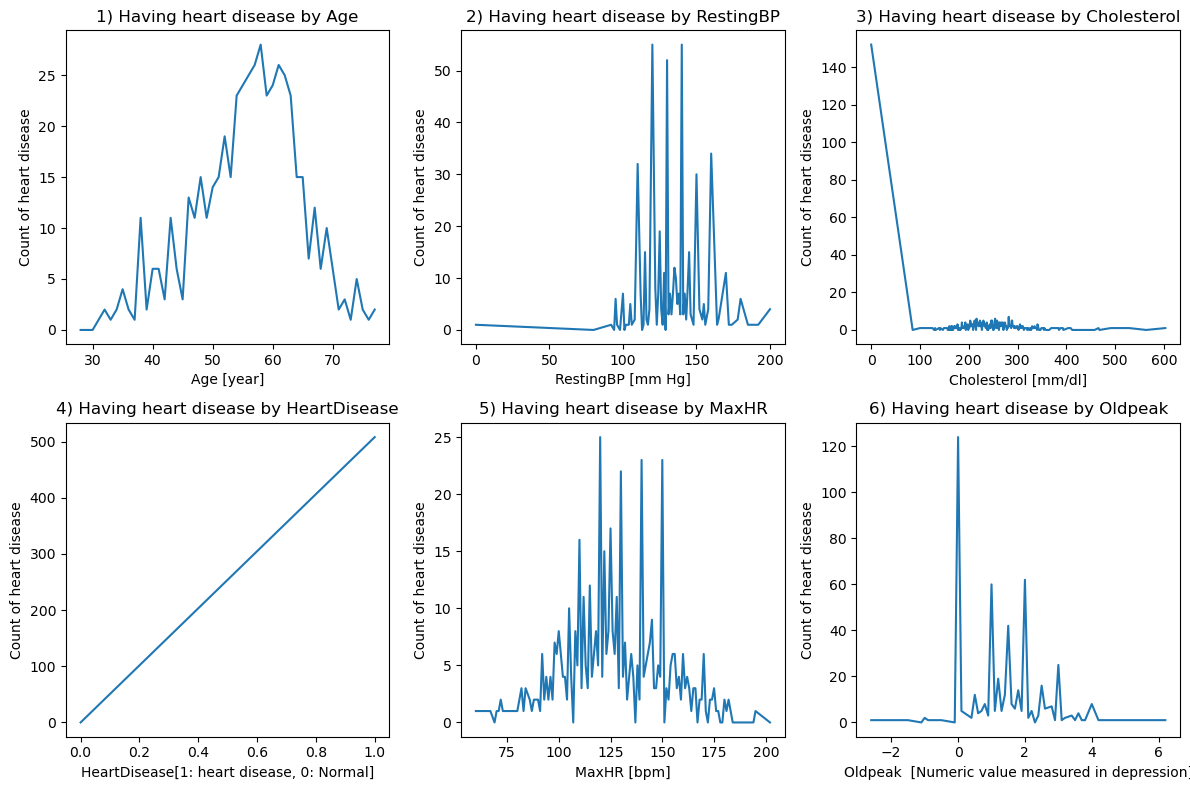

In [242]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
rows, cols = 2, 3

num_cols=['Age', 'RestingBP', 'Cholesterol', 'HeartDisease', 'MaxHR', 'Oldpeak']
name_cols = ['Age [year]', 'RestingBP [mm Hg]', 'Cholesterol [mm/dl]', 
             'HeartDisease[1: heart disease, 0: Normal]',
             'MaxHR [bpm]', 'Oldpeak  [Numeric value measured in depression]']

counter = 0

for row in range(rows):
    for col in range(cols):
        heart_disease = ds_heart.groupby(by = num_cols[counter])['HeartDisease'].sum()
        axs[row, col].plot(heart_disease.index.tolist(), heart_disease.tolist()) 
        axs[row, col].set_xlabel(name_cols[counter])
        axs[row, col].set_ylabel('Count of heart disease')
        axs[row, col].set_title(str(counter + 1) + ') Having heart disease by '+num_cols[counter])
        counter+=1
        
fig.tight_layout()
plt.show()

1) Люди 50-60 лет наиболее подвержены появлению сердечных заболеваний
2) Наименьшая вероятность возникновения сердечных заболеваний при артериальном давлении до 110, самое опасное 110-160
3) Если уровень холестирина равен 0, то наивысшая вероятность появления сердечных заболеваний
4) -
5) При максимальном ЧСС от 110 до 150 наибольшая вероятность возникновения сердечных заболеваний
6) Значение депрессии сегмента ST (отклонением от нормального базового уровня сегмента ST) на ЭКГ (электрокардиограмме) после физической нагрузки. Он является индикатором сердечной ишемии, что означает недостаточное поступление крови (и, следовательно, кислорода) в сердечную мышцу. С возрастом этот показатель увеличивается, что говорит о том, что физическую нагрузку с возрастом сердцу тяжелее переносить. При показателе от 0 до 2 наивысшая вероятность, где 0 наиболее популярный показатель в целом. Отрицательные значения есть только у 3 человек, и от 4 до 6 аналогично

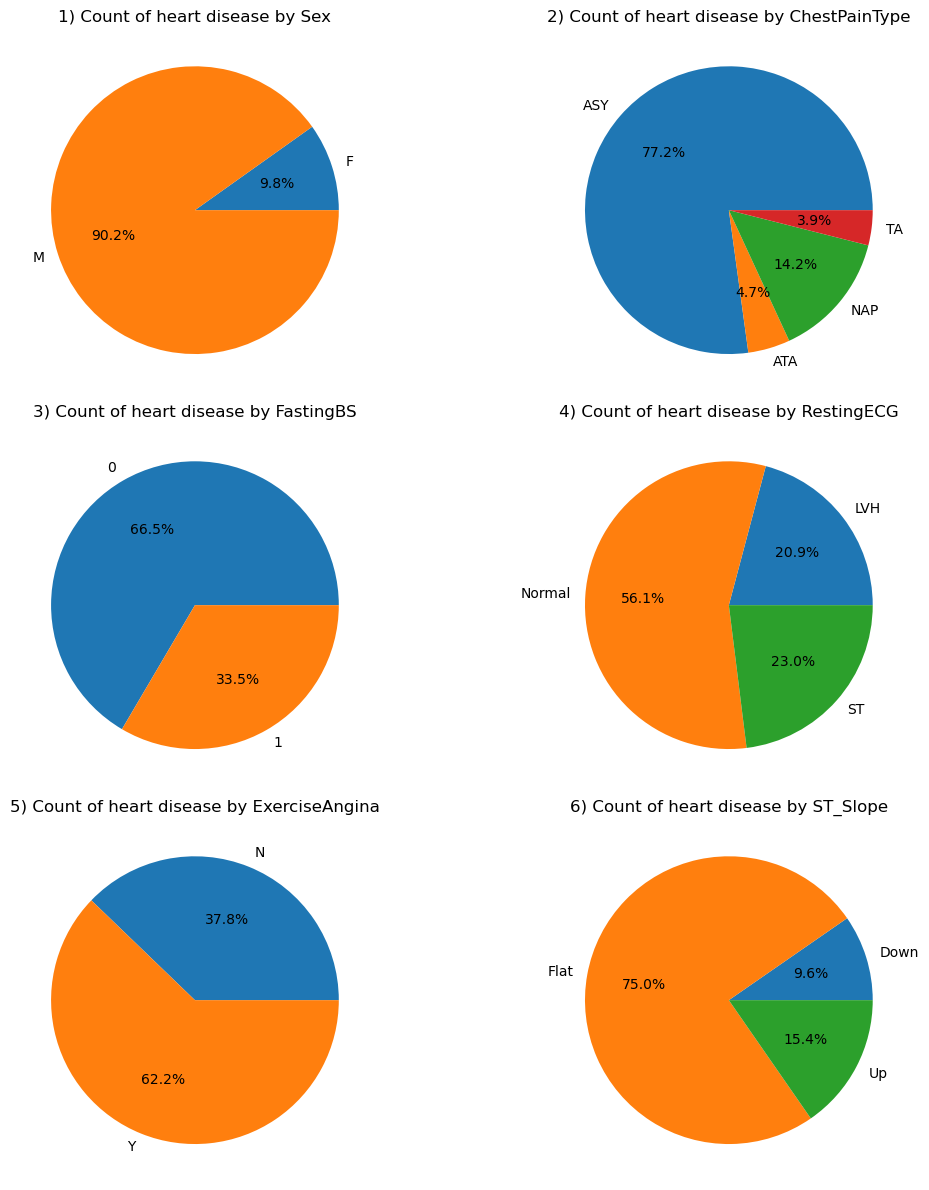

In [230]:
fig, axs = plt.subplots(3, 2, figsize=(12, 12))
rows, cols = 3, 2

categorical_features = ['Sex', 'ChestPainType', 'FastingBS', 'RestingECG', 'ExerciseAngina', 'ST_Slope']
counter = 0

for row in range(rows):
    for col in range(cols):
        count_category = ds_heart.groupby(by = categorical_features[counter])['HeartDisease'].sum()
        axs[row, col].pie(count_category, labels = count_category.index.tolist(), autopct='%1.1f%%')
        axs[row, col].set_title(str(counter + 1) + ') Count of heart disease by ' + categorical_features[counter])
        counter+=1
        
fig.tight_layout()
plt.show()


1) Мужчин с сердечными заболеваниями в 10 раз больше, чем женщин
2) Обычно бессимптомно или же боль в груди не связана с сердцем
3) Людей без диабета и с проблемами с сердцем больше, но в целом людей без диабета больше
4) ЭКГ примущественно без отклонений
5) Чаще проблемы с сердцем вызваны физической нагрузкой
6) St_slope отражает период между окончанием сокращения сердца и началом следующего сокращения, Up считается нормой, Down - признак ишемии (недостаточное кровоснабжение), flat - требуется дополнительное обследование. Последнее чаще всего